Num timesteps: 1000
Best mean reward: -inf - Last mean reward por episode: -205.47
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: -205.47 - Last mean reward por episode: -209.73
Num timesteps: 3000
Best mean reward: -205.47 - Last mean reward por episode: -212.05
Num timesteps: 4000
Best mean reward: -205.47 - Last mean reward por episode: -203.00
Saving new best model to tmp/best_model
Num timesteps: 5000
Best mean reward: -203.00 - Last mean reward por episode: -202.37
Saving new best model to tmp/best_model
Num timesteps: 6000
Best mean reward: -202.37 - Last mean reward por episode: -209.07
Num timesteps: 7000
Best mean reward: -202.37 - Last mean reward por episode: -208.45
Num timesteps: 8000
Best mean reward: -202.37 - Last mean reward por episode: -202.46
Num timesteps: 9000
Best mean reward: -202.37 - Last mean reward por episode: -200.37
Saving new best model to tmp/best_model
Num timesteps: 10000
Best mean reward: -200.37 - Last mean reward por

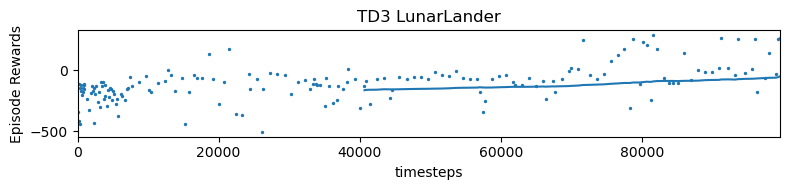

In [2]:
import os 
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt
from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf
    
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                if self.verbose >= 1:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward por episode: {mean_reward:.2f}")

                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    if self.verbose >= 1:
                        print(f"Saving new best model to {self.save_path}")

                    self.model.save(self.save_path)  

        return True

log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make("LunarLanderContinuous-v3")
env = Monitor(env, log_dir)

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
timesteps = 1e5
model.learn(total_timesteps=int(timesteps), callback=callback)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()